# Object Detection

## 1. OWLv2

### 1.1 Plotting OWLv2

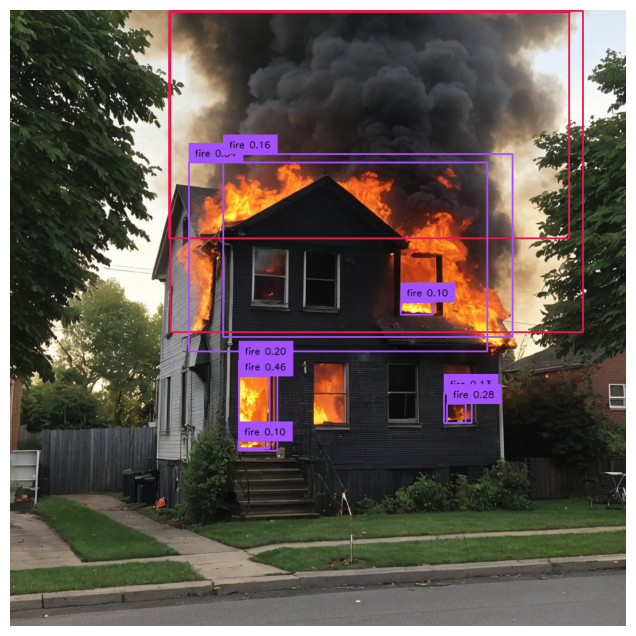

In [7]:
from autodistill_owlv2 import OWLv2
from autodistill.detection import CaptionOntology
from autodistill.utils import plot

import cv2

ontology = CaptionOntology({
    "fire": "fire",
    "smoke": "smoke"
    })

base_model = OWLv2(ontology=ontology)

detections = base_model.predict("images/house_00962_.png")

plot(
    image=cv2.imread("images/house_00962_.png"),
    detections=detections,
    classes=base_model.ontology.classes(),
)

### 1.2 Plotting OWLv2 with NMS (Non-Maximum Suppression)

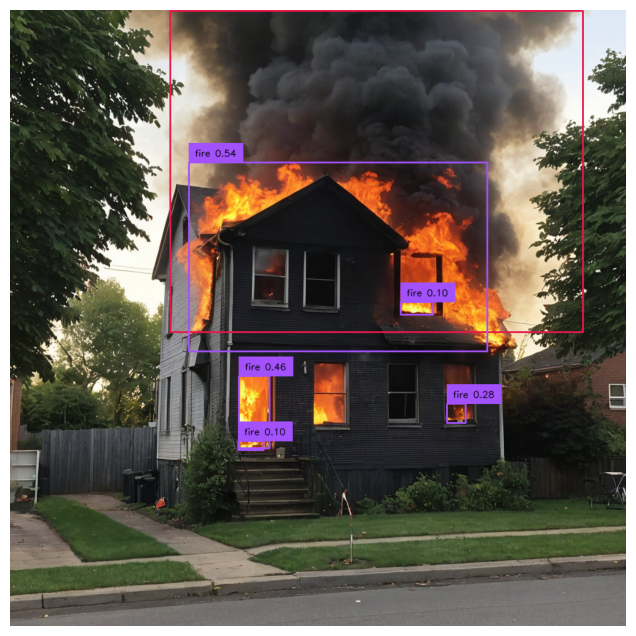

In [9]:
from autodistill_owlv2 import OWLv2
from autodistill.detection import CaptionOntology
from autodistill.utils import plot

import cv2

ontology = CaptionOntology({
    "fire": "fire",
    "smoke": "smoke"
    })

base_model = OWLv2(ontology=ontology)

detections = base_model.predict("images/house_00962_.png")

plot(
    image=cv2.imread("images/house_00962_.png"),
    detections=detections.with_nms(threshold=0.2),
    classes=base_model.ontology.classes(),
)

### 1.3 Labelling with OWLv2

In [ ]:
from autodistill.detection import CaptionOntology
from autodistill_owlv2 import OWLv2

IMAGE_DIR_PATH = "images"


ontology = CaptionOntology({
    "fire": "fire",
    "smoke": "smoke"
})

base_model = OWLv2(ontology=ontology)

In [ ]:
DATASET_DIR_PATH = "owlv2/test"

dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH,
)

### 1.4 Custom function to label with OWLv2 with NMS (Non-Maximum Suppression) 

In [ ]:
import os
import torch
from tqdm import tqdm
from PIL import Image
from torchvision.ops import nms
from transformers import Owlv2Processor, Owlv2ForObjectDetection

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def convert_to_yolo_format(image_size, box, label):
    # Convert bounding box coordinates to YOLO format
    xmin, ymin, xmax, ymax = box
    width, height = image_size
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    box_width = (xmax - xmin) / width
    box_height = (ymax - ymin) / height
    return f"{label} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}"

# def process_folder(input_folder, output_folder, nms_threshold=0.2, threshold=0.1):

def process_folder(input_folder, output_folder, nms_threshold=0.2):
    # Create output folders
    image_output_folder = os.path.join(output_folder, "images")
    label_output_folder = os.path.join(output_folder, "labels")
    os.makedirs(image_output_folder, exist_ok=True)
    os.makedirs(label_output_folder, exist_ok=True)

    # Load OwlV2 processor
    processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")

    # Load OwlV2 object detection model
    model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble").to(device)

    for filename in tqdm(os.listdir(input_folder), desc="Processing images", unit="image"):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(input_folder, filename)

            try:
                # Load image
                image = Image.open(file_path)

                # Provide text descriptions for the image
                texts = [["fire", "smoke"]]

                # Tokenize and process inputs
                inputs = processor(text=texts, images=image, return_tensors="pt").to(device)

                # Get raw model outputs
                outputs = model(**inputs)

                # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
                target_sizes = torch.Tensor([image.size[::-1]]).to(device)

                # Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
                results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes)

                # Apply NMS thresholding to the results
                for result in results:
                    boxes, scores, labels = result["boxes"], result["scores"], result["labels"]
                    keep = nms(boxes, scores, nms_threshold)
                    result["boxes"] = boxes[keep]
                    result["scores"] = scores[keep]
                    result["labels"] = labels[keep]

                # Retrieve predictions for the first image for the corresponding text queries
                i = 0
                text = texts[i]
                boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

                # Write YOLO format annotations to a text file
                annotation_filename = os.path.splitext(filename)[0] + ".txt"
                annotation_path = os.path.join(label_output_folder, annotation_filename)
                with open(annotation_path, "w") as output_file:
                    for box, score, label in zip(boxes, scores, labels):
                        box = [round(i, 2) for i in box.tolist()]
                        yolo_annotation = convert_to_yolo_format(image.size[::-1], box, label)
                        output_file.write(f"{yolo_annotation}\n")

                # Save the image to the output folder
                image.save(os.path.join(image_output_folder, filename))

            except ValueError as e:
                # Handle the specific ValueError related to channel dimension inference
                print(f"Skipping {filename} due to error: {e}")
                continue

    print(f"Dataset created in {output_folder}")

# Specify input and output folders
input_folder = "testset"
output_folder = "testset/data"

# Process the folder
process_folder(input_folder, output_folder)


## 2. GroundedDino

### 2.1 labelling with GroundedDino

In [ ]:
from autodistill.detection import CaptionOntology
from autodistill_grounding_dino import GroundingDINO

IMAGE_DIR_PATH = "images"

ontology = CaptionOntology({
    "fire": "fire",
    "smoke": "smoke"
})

base_model = GroundingDINO(ontology=ontology, box_threshold=0.25, text_threshold=0.25)

In [ ]:
DATASET_DIR_PATH = "grounded_dino/dataset"

dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH,
)

# Segmentation

## 1. GroundingSAM

In [ ]:
from autodistill.detection import CaptionOntology
from autodistill_grounded_sam import GroundedSAM

IMAGE_DIR_PATH = "fire-and-smoke-1/train/images"

ontology = CaptionOntology({
    "house" : "house",
})

base_model = GroundedSAM(ontology=ontology)

In [ ]:
DATASET_DIR_PATH = "grounding_sam/dataset"

dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH,
)

## 2. SAM-CLIP

In [ ]:
from autodistill_sam_clip import SAMCLIP
from autodistill.detection import CaptionOntology

IMAGE_DIR_PATH = "images"

ontology = CaptionOntology({
    "fire": "fire",
    "smoke": "smoke"
})

base_model = SAMCLIP(ontology=ontology)


In [ ]:
DATASET_DIR_PATH = "SAMCLIP/dataset"

dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH,
)